## 1: Install Dependencies
This cell installs all necessary libraries for the application to run.

In [ ]:
# -*- coding: utf-8 -*-
# Install all required libraries quietly
!pip install ipywidgets transformers torch sentencepiece huggingface_hub pypdf evaluate scikit-learn sentence-transformers matplotlib seaborn pandas nltk textstat rouge_score --quiet
# accelerate is needed for efficient multi-device model loading
!pip install accelerate --quiet
print("✅ All dependencies installed successfully.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00
✅ All dependencies installed successfully.


## 2: Import Libraries & Authenticate
This cell imports the required Python modules and securely logs into the Hugging Face Hub using your Colab secret.

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata
from huggingface_hub import login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import pypdf
import evaluate
import nltk
import io
import warnings
import time
import textstat
from math import pi

# --- 0. SETUP AND AUTHENTICATION ---
warnings.filterwarnings("ignore")

# CORRECTED: Download the 'punkt' resource and the specific 'punkt_tab' to fix the TextRank error
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True) # <-- This line explicitly fixes the error
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

# Securely get the token from Colab secrets
# Added a check for userdata.get to avoid the timeout in certain environments
HF_TOKEN = None
try:
    if 'userdata' in globals() and hasattr(userdata, 'get'):
      HF_TOKEN = userdata.get('HF_TOKEN')
      login(token=HF_TOKEN)
      print("✅ Hugging Face Hub login successful.")
    else:
      print("⚠️ Skipping Hugging Face Hub login. userdata.get is not available in this environment.")
except Exception as e:
    print(f"🛑 Hugging Face Hub login failed. Please ensure you have set the 'HF_TOKEN' secret correctly.")
    print(f"Error: {e}")

✅ Hugging Face Hub login successful.


## 3: Load AI Models (Pre-computation)
This crucial, one-time step loads all the AI models into memory before any UI is displayed. This ensures the application is fast and responsive during use.

In [ ]:
# --- 1. LOAD MODELS (PRE-COMPUTATION) ---
print("Loading small, fast models... This should be quicker now. ⏳")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model Dictionary to hold all loaded models
MODELS = {}

try:
    # Model 1: TinyLlama-1.1B-Chat (Open, 1.1B)
    model_id_tiny = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    MODELS['tinyllama'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_tiny),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_tiny,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        ),
        'name': "TinyLlama-1.1B-Chat"
    }
    print("✅ Loaded TinyLlama-1.1B-Chat.")

    # Model 2: Phi-1.5 (Restricted License, 1.3B)
    model_id_phi = "microsoft/phi-1.5"
    MODELS['phi'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_phi, trust_remote_code=True),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_phi,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        ),
        'name': "Phi-1.5"
    }
    print("✅ Loaded Phi-1.5.")

    # Model 3: BART (Public Baseline, ~400M)
    model_id_bart = "facebook/bart-large-cnn"
    MODELS['bart'] = {
        'summarizer': pipeline("summarization", model=model_id_bart, device=0 if device=="cuda" else -1),
        'name': 'BART-Large-CNN'
    }
    print("✅ Loaded BART-Large-CNN.")

    # Model 4: Sentence Transformer (for Extractive Baseline)
    MODELS['embedding'] = {
        'model': SentenceTransformer('all-MiniLM-L6-v2', device=device),
        'name': 'TextRank (Embeddings)'
    }
    print("✅ Loaded Sentence Transformer for TextRank.")

    # Model 5: Gemma (Requires authentication)
    model_id_gemma = "google/gemma-2b-it"
    try:
        MODELS['gemma'] = {
            'tokenizer': AutoTokenizer.from_pretrained(model_id_gemma),
            'model': AutoModelForCausalLM.from_pretrained(
                model_id_gemma,
                torch_dtype=torch.bfloat16,
                device_map="auto",
            ),
            'name': "Gemma-2B-IT"
        }
        print("✅ Loaded Gemma-2B-IT.")
    except Exception as gemma_e:
        print(f"🛑 Error loading Gemma-2B-IT: {gemma_e}. Please ensure you have accepted the terms and conditions on Hugging Face and your HF_TOKEN is set correctly.")


    print("\n🎉 All models loaded successfully!")
except Exception as e:
    print(f"🛑 Error loading models: {e}. Please check your token and model access permissions.")
    #exit() # Don't exit here, let the rest of the notebook run

rouge_metric = evaluate.load("rouge")

Loading small, fast models... This should be quicker now. ⏳
Using device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded TinyLlama-1.1B-Chat.


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

✅ Loaded Phi-1.5.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✅ Loaded BART-Large-CNN.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded Sentence Transformer for TextRank.


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Loaded Gemma-2B-IT.

🎉 All models loaded successfully!


## 4: Define Shared Backend Logic
This cell contains all the shared helper functions for processing text, running models, calculating the enhanced metrics, and creating plots. Both UIs will use these functions.



In [ ]:
# --- 2. SHARED BACKEND LOGIC ---

# --- Model Inference ---
def generate_with_chat_template_model(model_key, prompt, max_new_tokens=250):
    """Handles models like TinyLlama and Gemma that use a chat template."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    chat = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(formatted_prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
    outputs = model.generate(input_ids=inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

def generate_with_instruct_model(model_key, prompt, max_new_tokens=250):
    """Handles models like Phi that use a simple instruction format."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False).to(model.device)
    outputs = model.generate(**inputs, max_length=len(inputs["input_ids"][0]) + max_new_tokens)
    # Use split to robustly get the content after 'Output:'
    decoded_output = tokenizer.batch_decode(outputs)[0]
    if "Output:" in decoded_output:
        return decoded_output.split("Output:")[1].strip()
    return decoded_output # Fallback if format is unexpected


def summarize_abstractive(text, model_key, max_len=200, min_len=50):
    if model_key == 'tinyllama' or model_key == 'gemma': # Added Gemma here
        prompt = f"Provide a concise, abstractive summary of the following text:\n\n{text[:2000]}"
        return generate_with_chat_template_model(model_key, prompt, max_new_tokens=max_len)
    elif model_key == 'phi':
        prompt = f"Instruct: Summarize the following text concisely.\n{text[:2000]}\nOutput:"
        return generate_with_instruct_model(model_key, prompt, max_new_tokens=max_len)
    elif model_key == 'bart':
        return MODELS['bart']['summarizer'](text[:4096], max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
    return "Unsupported model."

def summarize_extractive(text, model_key, num_sentences=5):
    if model_key == 'tinyllama' or model_key == 'gemma': # Added Gemma here
        prompt = f"""Your task is extractive summarization. From the text below, extract the {num_sentences} most crucial sentences verbatim.\n\n{text[:2000]}"""
        return generate_with_chat_template_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'phi':
        prompt = f"Instruct: Extract the {num_sentences} most important sentences verbatim from the following text.\n{text[:2000]}\nOutput:"
        return generate_with_instruct_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'embedding':
        try:
            sentences = nltk.sent_tokenize(text)
            if len(sentences) <= num_sentences: return "\n".join(sentences)
            embeddings = MODELS['embedding']['model'].encode(sentences, convert_to_tensor=True)
            sim_matrix = cosine_similarity(embeddings.cpu().numpy())
            graph = nx.from_numpy_array(sim_matrix)
            scores = nx.pagerank(graph)
            ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
            return "\n".join([s for _, s in ranked_sentences[:num_sentences]])
        except Exception as e: return f"TextRank failed: {e}"
    return "Unsupported model."

# --- Enhanced Metrics and Visualization ---
def calculate_metrics(summary, original_text, processing_time):
    embedding_model = MODELS['embedding']['model']
    embeddings = embedding_model.encode([original_text, summary])
    semantic_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return {
        "ROUGE-1": round(rouge_metric.compute(predictions=[summary], references=[original_text])['rouge1'], 3),
        "ROUGE-2": round(rouge_metric.compute(predictions=[summary], references=[original_text])['rouge2'], 3),
        "Semantic Similarity": round(semantic_sim, 3),
        "Readability": round(textstat.flesch_reading_ease(summary), 2),
        "Length (words)": len(summary.split()),
        "Time (sec)": round(processing_time, 2),
        "Compression": f"{(1 - (len(summary.split()) / len(original_text.split()))) * 100:.1f}%" if len(original_text.split()) > 0 else "N/A"
    }

def create_bar_charts(metrics_df):
    if metrics_df.empty: return None
    df_sorted = metrics_df.sort_values(by=['Model']).reset_index(drop=True)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16)
    sns.barplot(data=df_sorted, x='Model', y='ROUGE-1', ax=axes[0], palette='viridis').tick_params(axis='x', rotation=45)
    axes[0].set_title('ROUGE-1 Score')
    sns.barplot(data=df_sorted, x='Model', y='Semantic Similarity', ax=axes[1], palette='viridis').tick_params(axis='x', rotation=45)
    axes[1].set_title('Semantic Similarity')
    sns.barplot(data=df_sorted, x='Model', y='Time (sec)', ax=axes[2], palette='viridis').tick_params(axis='x', rotation=45)
    axes[2].set_title('Processing Time (seconds)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def create_radar_chart(metrics_df):
    if metrics_df.empty: return None
    metrics_to_plot = ['ROUGE-1', 'Semantic Similarity', 'Readability']
    df_radar = metrics_df.copy()
    df_radar['Readability'] = np.clip(df_radar['Readability'] / 100.0, 0, 1)
    df_avg = df_radar.groupby('Model')[metrics_to_plot].mean().reset_index()
    labels, num_vars = df_avg.columns[1:], len(df_avg.columns[1:])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in df_avg.iterrows():
        values = row.drop('Model').tolist() + [row.drop('Model').tolist()[0]]
        ax.plot(angles, values, label=row['Model'], linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticklabels([]); ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title("Multi-Metric Model Comparison", size=15, y=1.1)
    return fig

print("✅ Shared backend functions are defined.")

✅ Shared backend functions are defined.


## Section A: Summarize with All Models (Prompt UI)
This UI is simplified for quick comparisons. Just paste your text, choose the summary type, and it will automatically run all compatible models.



Your max_length is set to 200, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


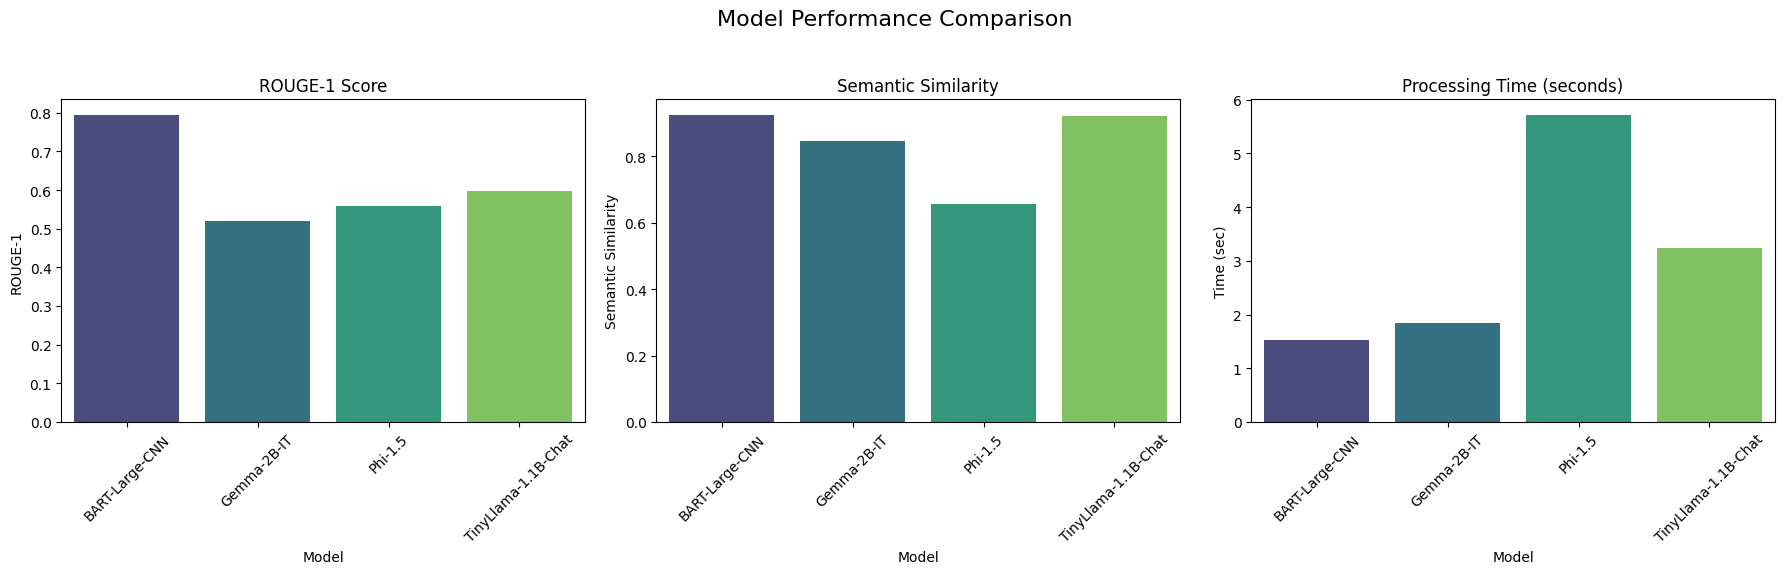

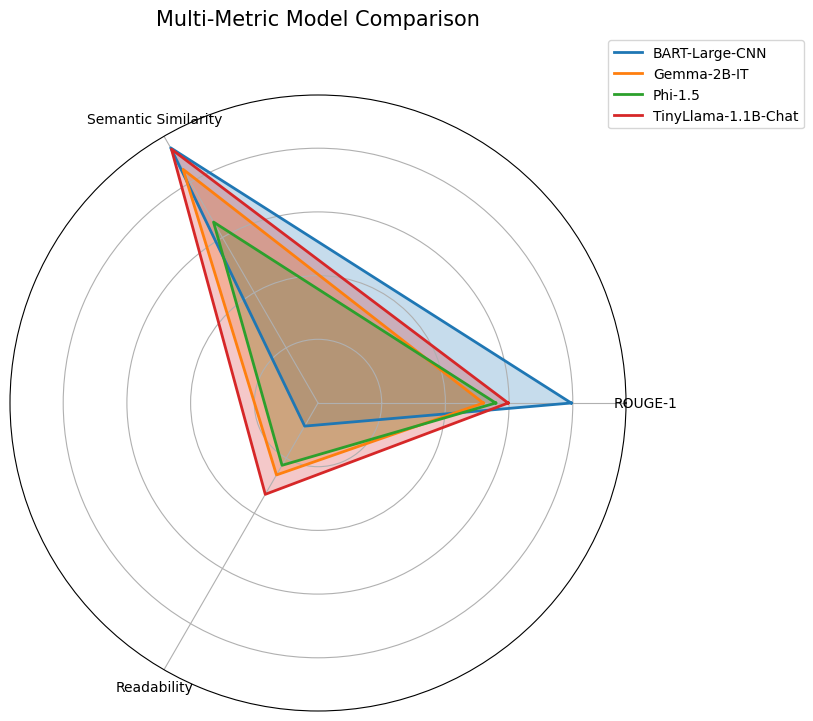

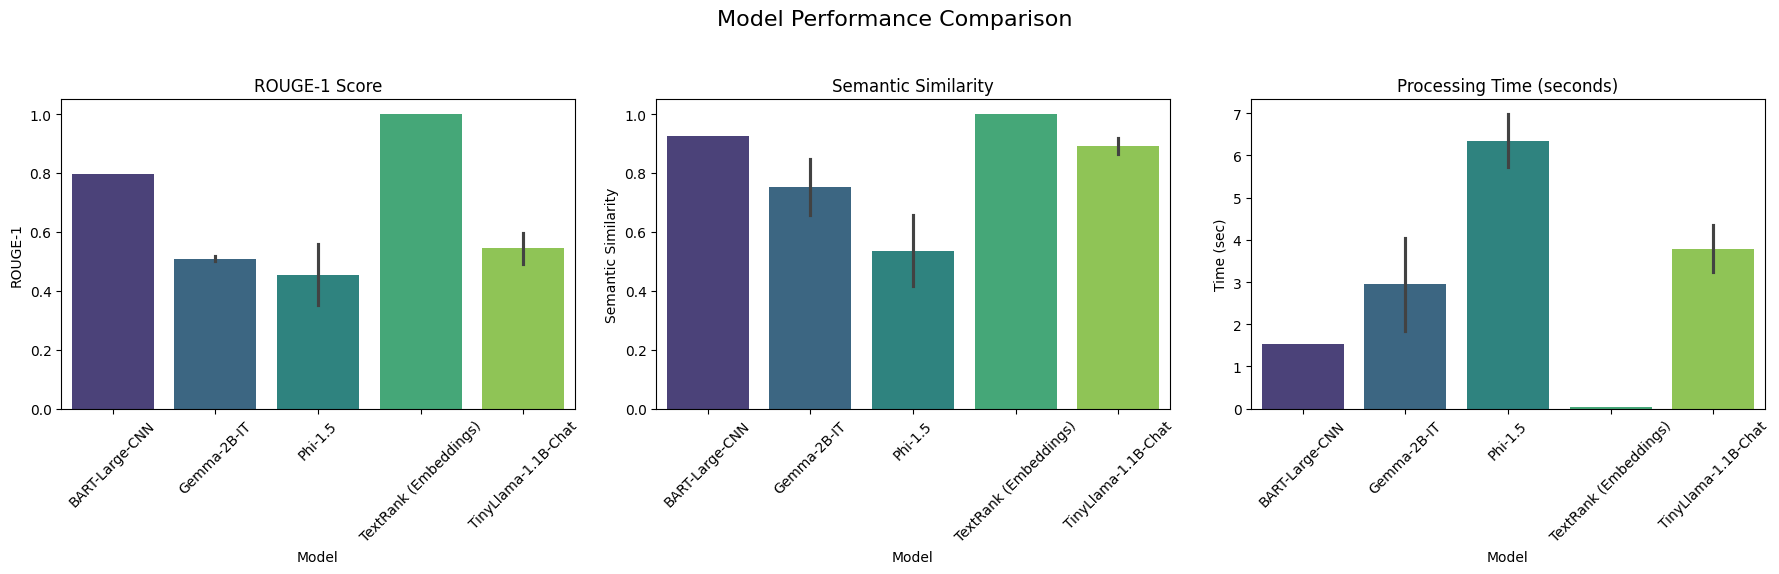

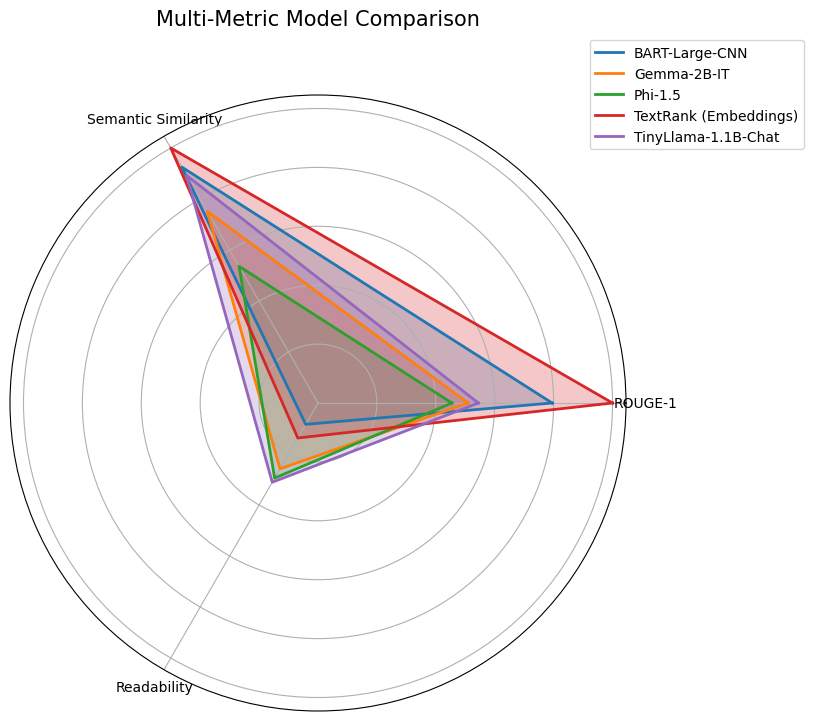

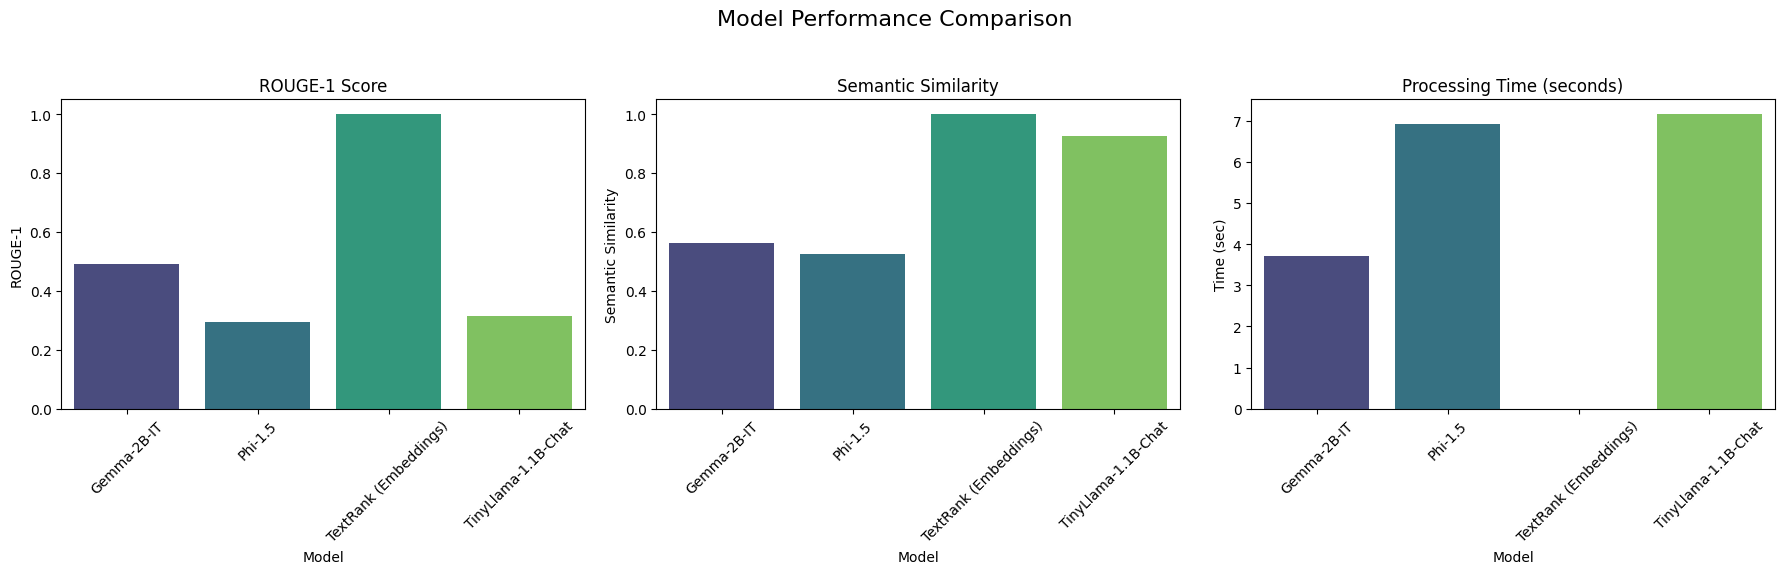

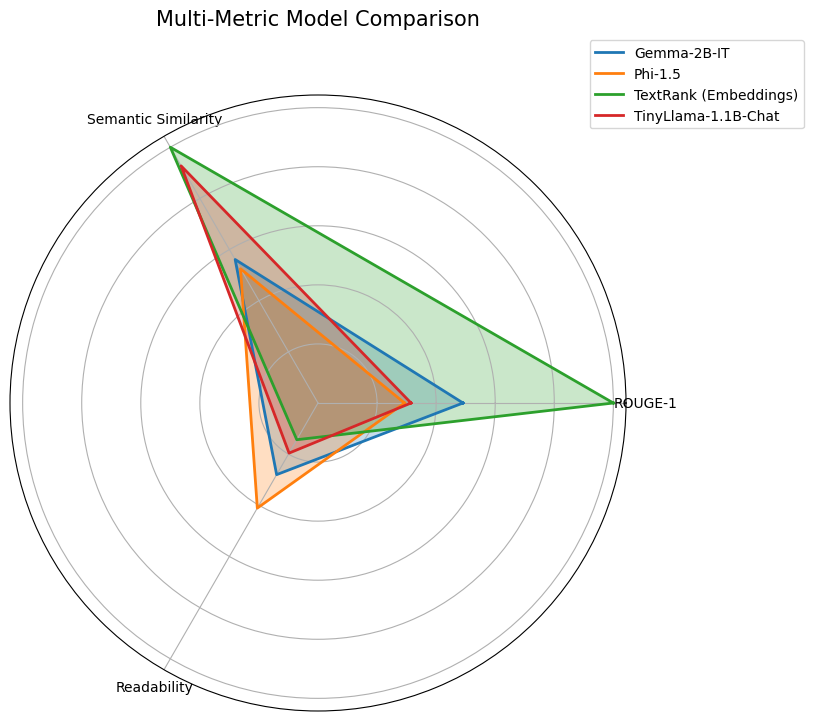

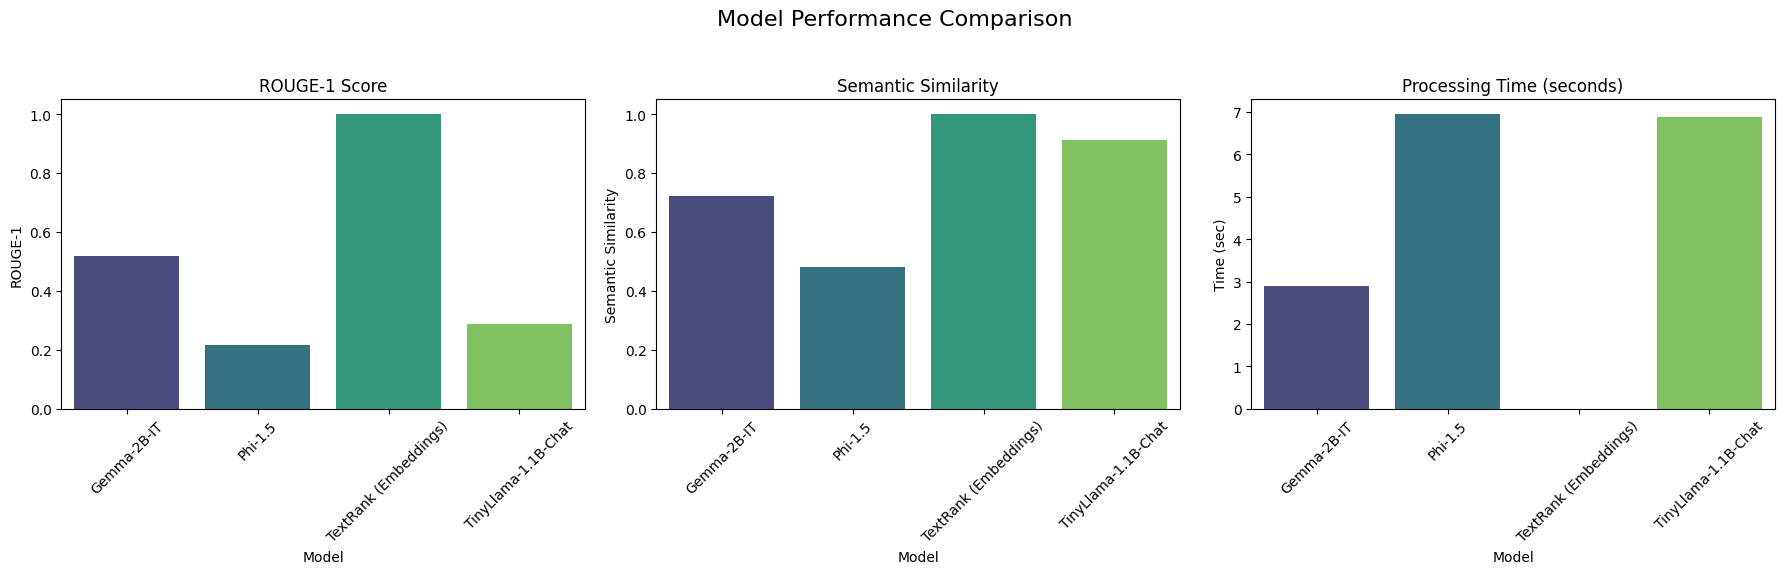

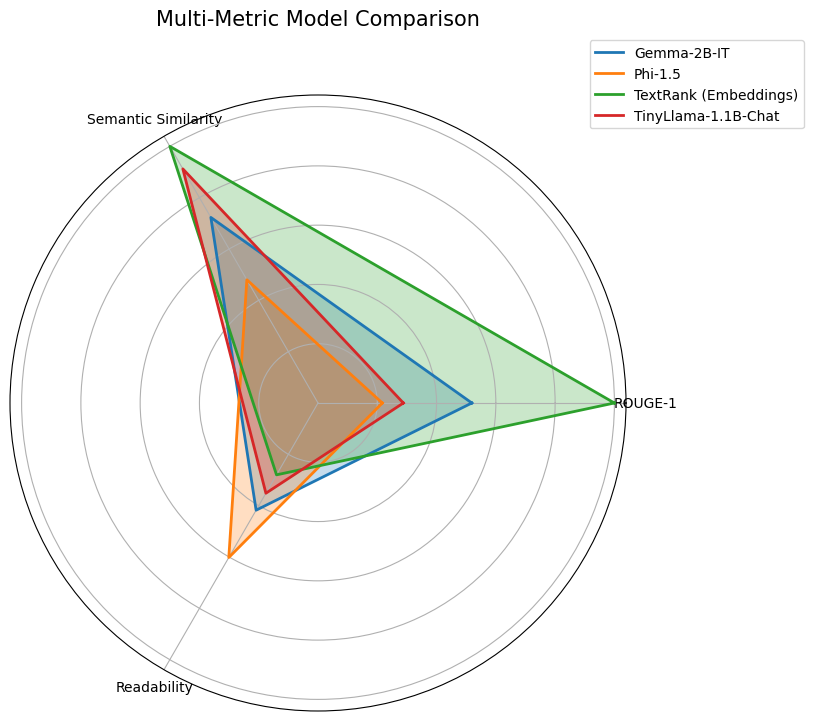

In [ ]:
# --- SECTION A: RUN ALL MODELS UI ---

# --- State and Choices ---
metrics_history_all = []
abstractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'bart', 'gemma']}
extractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'embedding', 'gemma']}

# --- UI Widget Definitions ---
header_all = widgets.HTML("<h2>Section A: Summarize with All Models</h2><p>Paste text and choose a summary type. The system will automatically run all compatible models for a full comparison.</p>")
prompt_input_all = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_all = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
generate_button_all = widgets.Button(description='🚀 Generate All Summaries', button_style='primary', icon='cogs')
clear_button_all = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_all = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_all = widgets.Output()
bar_plot_output_all = widgets.Output()
radar_plot_output_all = widgets.Output()
output_accordion_all = widgets.Accordion(children=[metrics_table_output_all, bar_plot_output_all, radar_plot_output_all])
output_accordion_all.set_title(0, '📊 Metrics Table'); output_accordion_all.set_title(1, '📈 Bar Charts'); output_accordion_all.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def on_generate_button_clicked_all(b):
    generate_button_all.disabled = True; generate_button_all.description = "Processing..."
    original_text, s_type = prompt_input_all.value, summary_type_all.value
    if not original_text.strip():
        with summary_output_all: print("⚠️ Please paste text to summarize.")
        generate_button_all.disabled = False; generate_button_all.description = "🚀 Generate All Summaries"; return

    s_keys = list(abstractive_model_choices.values()) if s_type == 'Abstractive' else list(extractive_model_choices.values())

    with summary_output_all: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_all: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_all: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_all.append(metrics)

    df = pd.DataFrame(metrics_history_all)
    with metrics_table_output_all: metrics_table_output_all.clear_output(wait=True); display(df)
    with bar_plot_output_all: bar_plot_output_all.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_all: radar_plot_output_all.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_all.disabled = False; generate_button_all.description = "🚀 Generate All Summaries"

def on_clear_button_clicked_all(b):
    global metrics_history_all; metrics_history_all = []
    summary_output_all.clear_output(); metrics_table_output_all.clear_output()
    bar_plot_output_all.clear_output(); radar_plot_output_all.clear_output()
    prompt_input_all.value = ""
    with summary_output_all: print("Outputs cleared.")

generate_button_all.on_click(on_generate_button_clicked_all)
clear_button_all.on_click(on_clear_button_clicked_all)

# --- Assemble and Display UI with FIXED Layout ---
input_controls_all = widgets.VBox(
    [prompt_input_all, summary_type_all, widgets.HBox([generate_button_all, clear_button_all])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_all = widgets.VBox(
    [summary_output_all, output_accordion_all],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_all = widgets.VBox([header_all, widgets.HBox([input_controls_all, output_area_all])])

display(app_all)

## Section B: Summarize with Specific Models (Checkbox UI)
This UI gives you fine-grained control, allowing you to select exactly which models you want to run using checkboxes.



Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


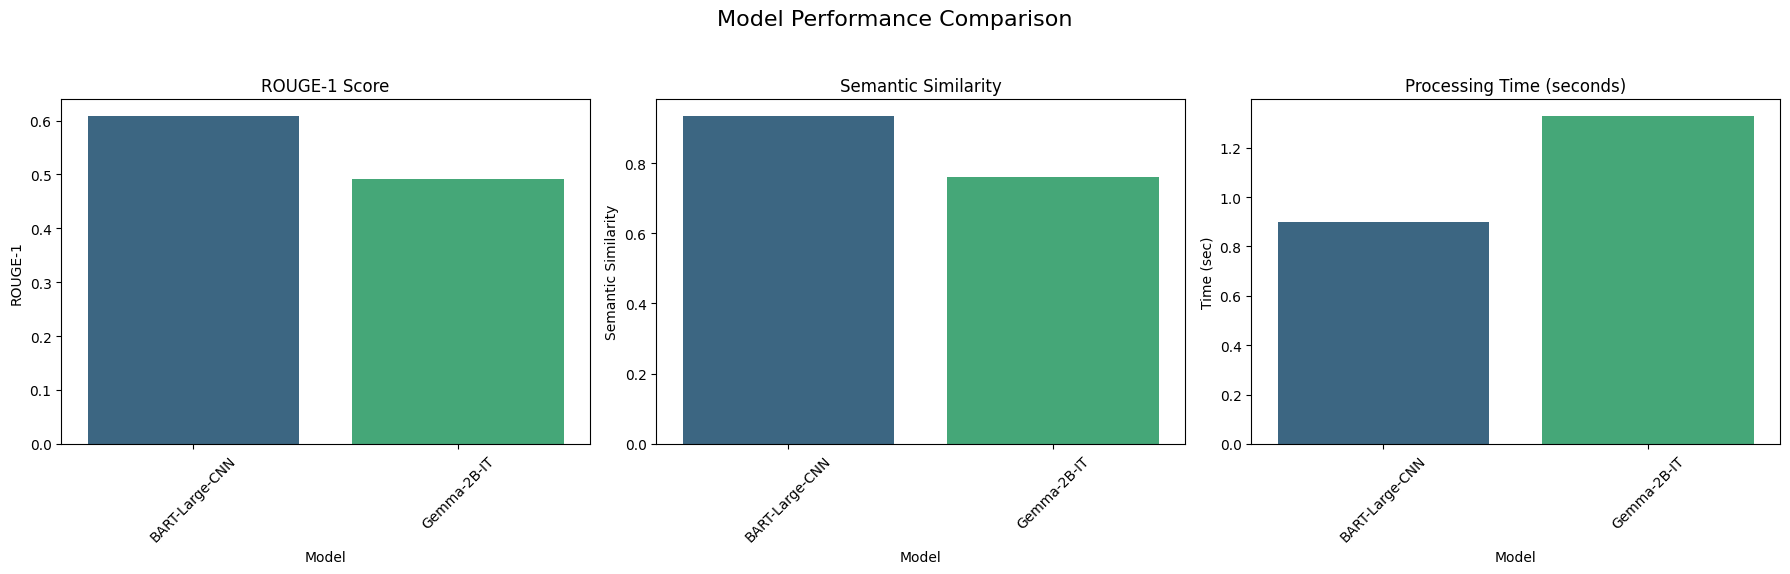

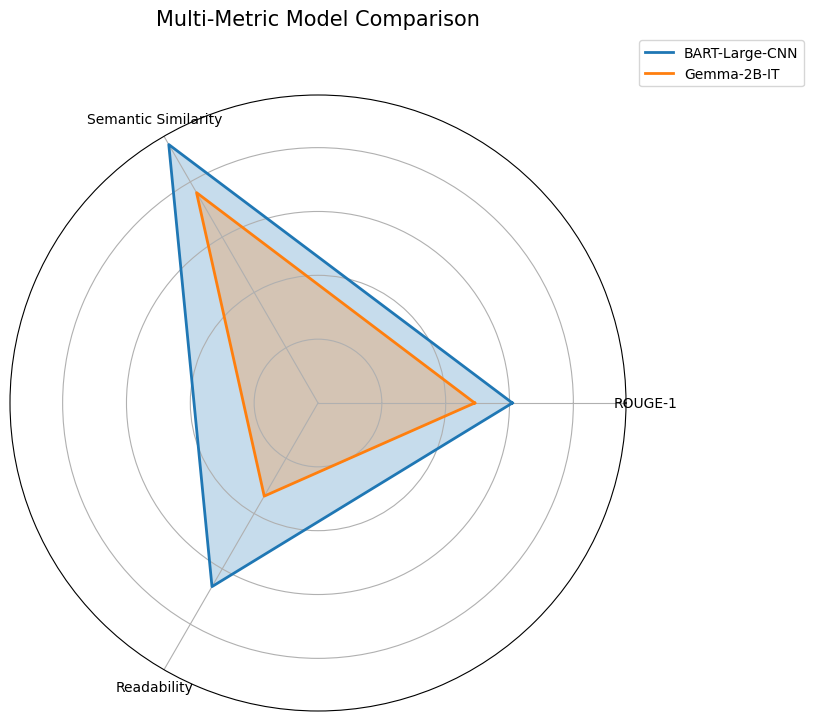

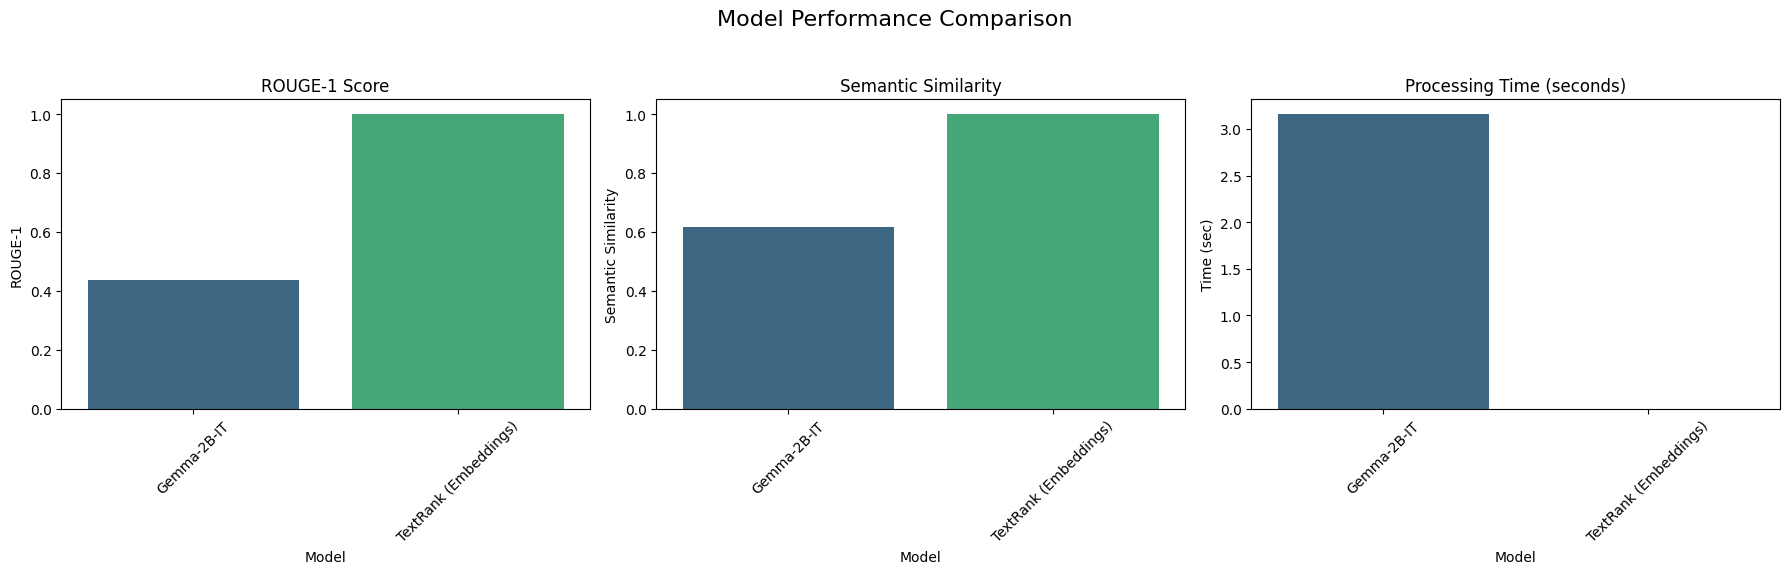

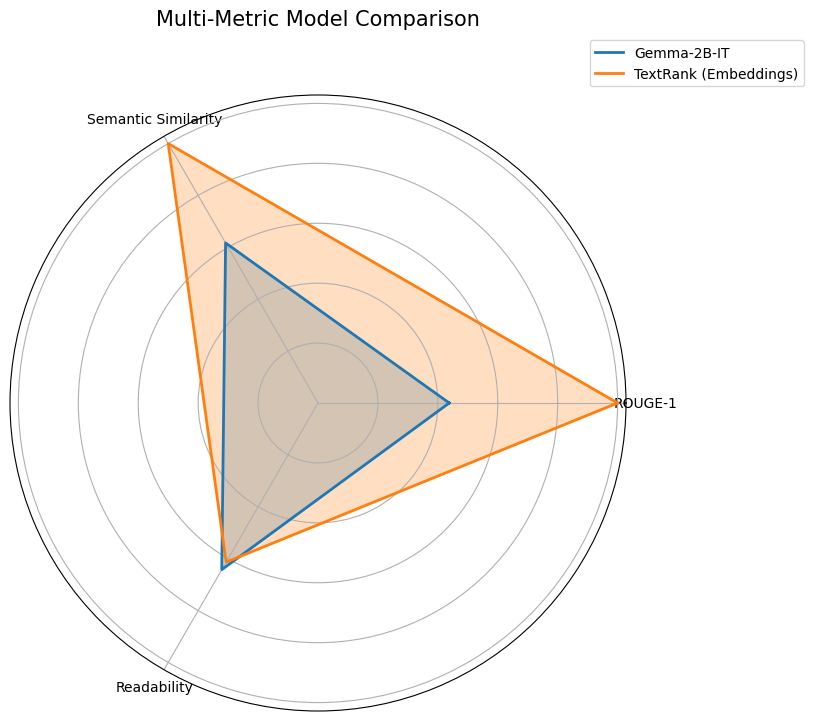

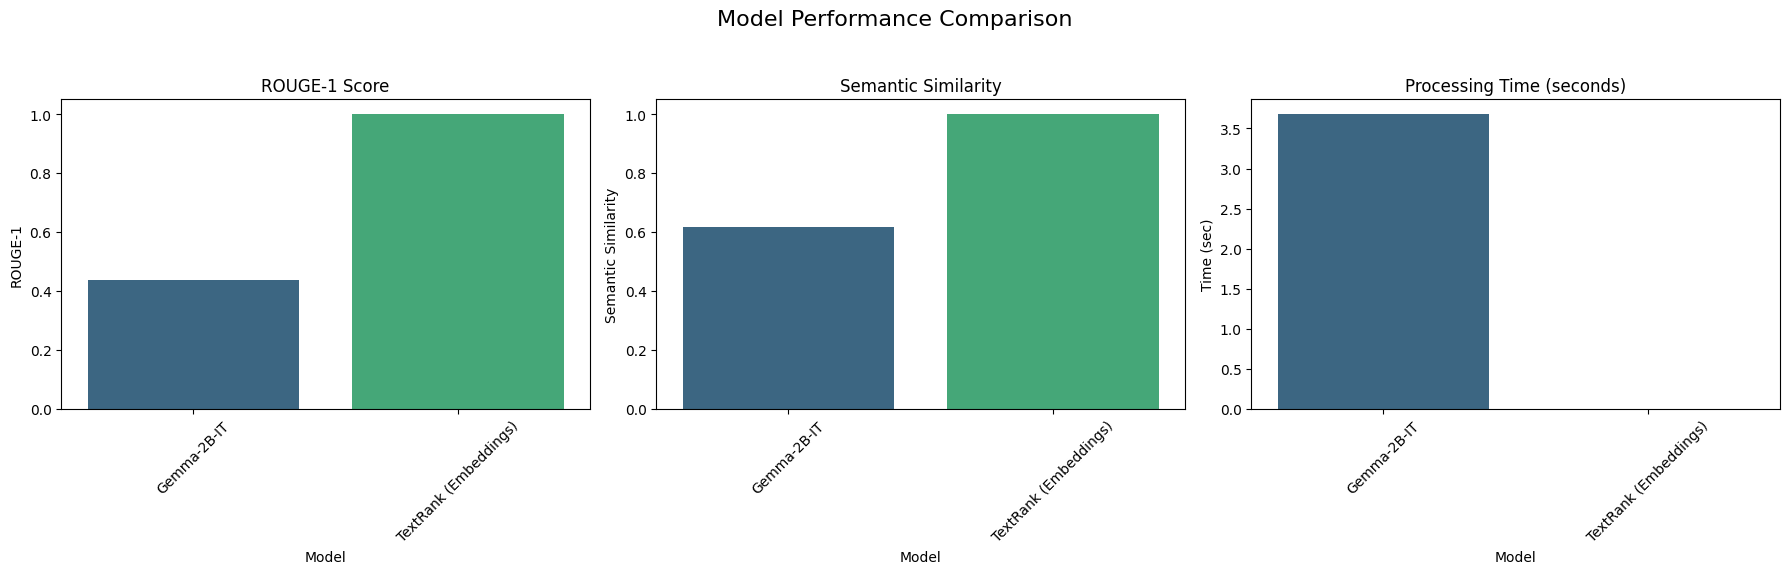

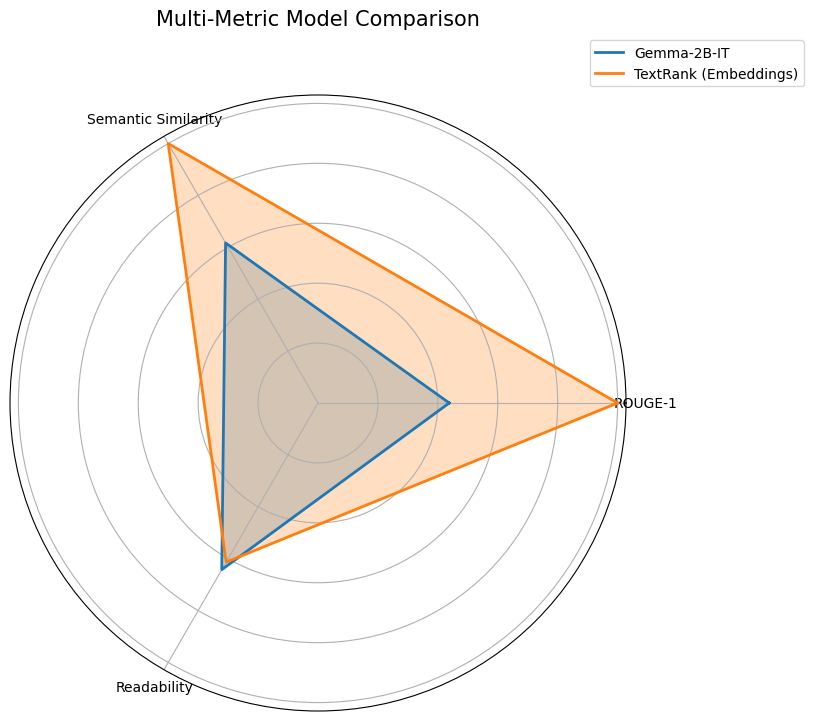

In [ ]:
# --- SECTION B: SELECT SPECIFIC MODELS UI ---

# --- State and Choices ---
metrics_history_specific = []
# (Choices are reused from Section A)
abstractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'bart', 'gemma']}
extractive_model_choices = {MODELS[k]['name']: k for k in ['tinyllama', 'phi', 'embedding', 'gemma']}

# --- UI Widget Definitions ---
header_specific = widgets.HTML("<h2>Section B: Summarize with Specific Models</h2><p>Paste text, choose a summary type, and check the specific models you want to run.</p>")
prompt_input_specific = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_specific = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
model_checkboxes_out = widgets.Output() # A container for our dynamic checkboxes
checkboxes = {}
generate_button_specific = widgets.Button(description='🚀 Generate Summaries', button_style='primary', icon='cogs')
clear_button_specific = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_specific = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()
output_accordion_specific = widgets.Accordion(children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific])
output_accordion_specific.set_title(0, '📊 Metrics Table'); output_accordion_specific.set_title(1, '📈 Bar Charts'); output_accordion_specific.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def update_checkboxes(s_type):
    global checkboxes; checkboxes = {}
    choices = abstractive_model_choices if s_type == 'Abstractive' else extractive_model_choices
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        for name, key in choices.items():
            checkboxes[key] = widgets.Checkbox(value=True, description=name)
        display(widgets.VBox(list(checkboxes.values())))

def on_generate_button_clicked_specific(b):
    generate_button_specific.disabled = True; generate_button_specific.description = "Processing..."
    original_text, s_type = prompt_input_specific.value, summary_type_specific.value
    s_keys = [key for key, cb in checkboxes.items() if cb.value]

    if not original_text.strip() or not s_keys:
        with summary_output_specific: print("⚠️ Please paste text and check at least one model.")
        generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"; return

    with summary_output_specific: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_specific: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_specific: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_specific.append(metrics)

    df = pd.DataFrame(metrics_history_specific)
    with metrics_table_output_specific: metrics_table_output_specific.clear_output(wait=True); display(df)
    with bar_plot_output_specific: bar_plot_output_specific.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_specific: radar_plot_output_specific.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_specific.disabled = False; generate_button_specific.description = "🚀 Generate Summaries"

def on_clear_button_clicked_specific(b):
    global metrics_history_specific; metrics_history_specific = []
    summary_output_specific.clear_output(); metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output(); radar_plot_output_specific.clear_output()
    prompt_input_specific.value = ""
    with summary_output_specific: print("Outputs cleared.")

def on_summary_type_change_specific(change):
    update_checkboxes(change.new)

generate_button_specific.on_click(on_generate_button_clicked_specific)
clear_button_specific.on_click(on_clear_button_clicked_specific)
summary_type_specific.observe(on_summary_type_change_specific, names='value')

# --- Assemble and Display UI with FIXED Layout ---
input_controls_specific = widgets.VBox(
    [prompt_input_specific, summary_type_specific, widgets.Label("Select Models:"), model_checkboxes_out, widgets.HBox([generate_button_specific, clear_button_specific])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_specific = widgets.VBox(
    [summary_output_specific, output_accordion_specific],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_specific = widgets.VBox([header_specific, widgets.HBox([input_controls_specific, output_area_specific])])

# Initial population of checkboxes
update_checkboxes('Abstractive')

display(app_specific)